## Learning diffusivity (m) to solution (u) map for Poisson problem (Implementation 2)

Data is located in `../data` directory, and key data of our interest is in `Poisson_samples.npz` file. We would also need the mesh data in files with names `Poisson_m_mesh` and `Poisson_u_mesh` for plotting.

> Implementation is from [base_example_to_try_different_implementations/from_GideonIlung_deeponet.ipynb](../../../base_example_to_try_different_implementations/from_GideonIlung_deeponet.ipynb) which is based on [DeepONet](https://github.com/GideonIlung/DeepONet) repository. This method uses `pytorch`.

### Results
Below shows the neural operator prediction for different samples of test input. 

<p align="center"> <img src="Results_implement2/neural_operator_prediction_comparison.png" width="800"> </p>

In [2]:
import sys
import os
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy as np

import dolfin as dl

util_path = "../../../utilities/"
sys.path.append(util_path)
from plotUtilities import field_plot_fenics

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# set seed
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

In [3]:
data_folder = '../data/'
current_directory = os.getcwd()  
results_dir = current_directory + '/Results_implement2/'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

## Data related methods

In [4]:
class DataHandler(Dataset):
    def __init__(self, X_train_, X_trunk_, Y_train_, convert_to_tensor=True):

        self.X_train = self.convert_np_to_tensor(X_train_) if convert_to_tensor else X_train_

        if X_trunk_ is None:
            self.X_trunk = None
        else:
            self.X_trunk = self.convert_np_to_tensor(X_trunk_) if convert_to_tensor else X_trunk_
        
        self.Y_train = self.convert_np_to_tensor(Y_train_) if convert_to_tensor else Y_train_

    def convert_np_to_tensor(self,array):
        if isinstance(array, np.ndarray):
            # Convert NumPy array to PyTorch tensor
            tensor = torch.from_numpy(array)
            return tensor.to(torch.float32)
        else:
            return array
    
    def __len__(self):
        return len(self.Y_train)  # Assuming X_train and X_trunk have the same length as y

    def __getitem__(self, index):
        if self.X_trunk is None:
            return self.X_train[index,:], self.Y_train[index,:]
        else:
            return self.X_train[index,:], self.X_trunk, self.Y_train[index,:]

In [5]:
class DataProcessor:
    def __init__(self, data_file_name = '../problems/poisson/data/Poisson_samples.npz', \
                 num_train = 1900, num_test = 100, \
                 num_inp_fn_points = 2601, num_out_fn_points = 2601, \
                 num_Y_components = 1, \
                 num_inp_red_dim = None, num_out_red_dim = None):
        
        self.data = np.load(data_file_name)
        self.num_train = num_train
        self.num_test = num_test
        self.num_inp_fn_points = num_inp_fn_points
        self.num_out_fn_points = num_out_fn_points
        self.num_Y_components = num_Y_components 
        self.num_inp_red_dim = num_inp_red_dim
        self.num_out_red_dim = num_out_red_dim

        self.data, self.X_trunk, self.X_train, self.X_test, \
            self.X_train_mean, self.X_train_std, \
            self.X_train_svd_projector, self.X_train_s_values, \
            self.tol = self.load_X_data(self.data)
        
        self.Y_train, self.Y_test, \
            self.Y_train_mean, self.Y_train_std, \
            self.Y_train_svd_projector, self.Y_train_s_values \
            = self.load_Y_data(self.data)

        self.X_trunk_min = np.min(self.X_trunk, axis = 0)
        self.X_trunk_max = np.max(self.X_trunk, axis = 0)

    def load_X_data(self, data, tol = 1.0e-9):

        # trunk input data ('xi' coordinates)
        X_trunk = data['u_mesh_nodes']
        
        # branch input data ('m' functions)
        X_train = data['m_samples'][:self.num_train,:]
        X_test = data['m_samples'][self.num_train:(self.num_train + self.num_test),:]

        X_train_mean = np.mean(X_train, 0)
        X_train_std = np.std(X_train, 0)

        X_train = (X_train - X_train_mean)/(X_train_std + tol)
        X_test = (X_test - X_train_mean)/(X_train_std + tol)

        if self.num_inp_red_dim is not None:
            # compute SVD of input data 
            X_train_svd_projector, X_train_s_values = self.compute_svd(X_train, self.num_inp_red_dim, is_data_centered = True)

            # define training and testing data in the reduced dimension
            X_train = np.dot(X_train, X_train_svd_projector.T)
            X_test = np.dot(X_test, X_train_svd_projector.T)
        else:
            X_train_svd_projector = None
            X_train_s_values = None

        return data, X_trunk, X_train, X_test, \
               X_train_mean, X_train_std, \
               X_train_svd_projector, X_train_s_values, \
               tol 
    
    def load_Y_data(self, data, tol = 1.0e-9):

        # trunk input data ('xi' coordinates)
        X_trunk = data['u_mesh_nodes']
        
        # output data ('u' functions)
        Y_train = data['u_samples'][:self.num_train,:]
        Y_test = data['u_samples'][self.num_train:(self.num_train + self.num_test),:]

        if self.num_out_fn_points * self.num_Y_components != Y_train.shape[1]:
            raise ValueError('num_out_fn_points does not match the number of output function points in the data')
        
        Y_train_mean = np.mean(Y_train, 0)
        Y_train_std = np.std(Y_train, 0)

        Y_train = (Y_train - Y_train_mean)/(Y_train_std + tol)
        Y_test = (Y_test - Y_train_mean)/(Y_train_std + tol)

        if self.num_out_red_dim is not None:
            # compute SVD of output data 
            Y_train_svd_projector, Y_train_s_values = self.compute_svd(Y_train, self.num_out_red_dim, is_data_centered = True)

            # define training and testing data in the reduced dimension
            Y_train = np.dot(Y_train, Y_train_svd_projector.T)
            Y_test = np.dot(Y_test, Y_train_svd_projector.T)
        else:
            Y_train_svd_projector = None
            Y_train_s_values = None
        
        return Y_train, Y_test, \
               Y_train_mean, Y_train_std, \
               Y_train_svd_projector, Y_train_s_values
        
    def encoder_Y(self, x):
        x = (x - self.Y_train_mean)/(self.Y_train_std + self.tol)
        if self.Y_train_svd_projector is not None:
            return self.project_SVD(x, self.Y_train_svd_projector)
        else:
            return x
    
    def decoder_Y(self, x):
        # first lift the data to the original dimension
        if self.Y_train_svd_projector is not None:
            x = self.lift_SVD(x, self.Y_train_svd_projector)

        x = x*(self.Y_train_std + self.tol) + self.Y_train_mean
        return x
    
    def encoder_X(self, x):
        x = (x - self.X_train_mean)/(self.X_train_std + self.tol)
        if self.X_train_svd_projector is not None:
            return self.project_SVD(x, self.X_train_svd_projector)
        else:
            return x
    
    def decoder_X(self, x):
        # first lift the data to the original dimension
        if self.X_train_svd_projector is not None:
            x = self.lift_SVD(x, self.X_train_svd_projector)

        x = x*(self.X_train_std + self.tol) + self.X_train_mean
        return x
    
    def compute_svd(self, data, num_red_dim, is_data_centered = False):
        if is_data_centered == False:
            data_mean = np.mean(data, 0)
            data = data - data_mean
        U, S, _ = np.linalg.svd(data.T, full_matrices = False)
        projector = U[:, :num_red_dim].T # size num_red_dim x dim(X_train[0])
        return projector, S
    
    def project_SVD(self, data, Pi):
        return np.dot(data, Pi.T)
    
    def lift_SVD(self, data, Pi):
        return np.dot(data, Pi)

## Define network methods

In [6]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, depth, act):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        self.act = act 

        # Input layer
        self.layers.append(nn.Linear(input_size, hidden_size))
        
        # Hidden layers
        for _ in range(depth - 2):
            self.layers.append(nn.Linear(hidden_size, hidden_size))
        
        # Output layer
        self.layers.append(nn.Linear(hidden_size, num_classes))

        
    def forward(self, x,final_act=False):
        for i in range(len(self.layers) - 1):
            x = self.act(self.layers[i](x))
        x = self.layers[-1](x)  # No activation after the last layer

        if final_act == False:
            return x
        else:
            return torch.relu(x)

In [7]:
class DeepONet(nn.Module):
    
    def __init__(self, num_layers, num_neurons, act, \
                 num_br_outputs, num_tr_outputs, \
                 num_inp_fn_points, \
                 out_coordinate_dimension, \
                 num_Y_components):

        super(DeepONet, self).__init__()

        self.num_inp_fn_points = num_inp_fn_points
        self.num_br_outputs = num_br_outputs
        self.num_tr_outputs = num_tr_outputs
        self.out_coordinate_dimension = out_coordinate_dimension
        self.num_Y_components = num_Y_components

        #creating the branch network#
        self.branch_net = MLP(input_size=num_inp_fn_points, \
                              hidden_size=num_neurons, \
                              num_classes=num_br_outputs, \
                              depth=num_layers, \
                              act=act)
        self.branch_net.float()

        #creating the trunk network#
        self.trunk_net = MLP(input_size=out_coordinate_dimension, \
                             hidden_size=num_neurons, \
                             num_classes=num_tr_outputs, \
                             depth=num_layers, \
                             act=act)
        self.trunk_net.float()
        
        self.bias = [nn.Parameter(torch.ones((1,)),requires_grad=True) for i in range(num_Y_components)]

        self.num_Y_components = num_Y_components

        # Logger
        self.train_loss_log = []
        self.test_loss_log = []
    
    def convert_np_to_tensor(self,array):
        if isinstance(array, np.ndarray):
            # Convert NumPy array to PyTorch tensor
            tensor = torch.from_numpy(array)
            return tensor.to(torch.float32)
        else:
            return array

    
    def forward(self, batch):

        X_train = self.convert_np_to_tensor(batch['X_train'])
        X_trunk = self.convert_np_to_tensor(batch['X_trunk'])
        
        branch_out = self.branch_net.forward(X_train)
        trunk_out = self.trunk_net.forward(X_trunk,final_act=True)

        if self.num_Y_components > 1:
            # for multiple output components we need to split the output of the branch network
            output = []
            for i in range(self.num_Y_components):
                output.append(branch_out[:,i*self.num_tr_outputs:(i+1)*self.num_tr_outputs] @ trunk_out.t() + self.bias[i])
            
            # stack and reshape to have output in batch_size x output_components format
            output = torch.stack(output, dim=-1)
            output = output.reshape(-1, X_trunk.shape[0] * self.num_Y_components)

            # output_1 = branch_out[:,:self.num_tr_outputs] @ trunk_out.t() + self.bias[0]
            # output_2 = branch_out[:,self.num_tr_outputs:] @ trunk_out.t() + self.bias[1]
            # output = torch.stack((output_1, output_2), dim=-1)
            # output = output.reshape(-1, X_trunk.shape[0] * X_trunk.shape[1])
        else:
            output = branch_out @ trunk_out.t() + self.bias[0]

        return output
    
    def train(self, train_data, test_data, batch_size=32, epochs = 1000, \
              lr=0.001, log=True, \
              loss_print_freq = 100):

        self.epochs = epochs
        self.batch_size = batch_size

        dataset = DataHandler(train_data['X_train'], \
                              train_data['X_trunk'], train_data['Y_train'])
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True) 

        X_trunk = dataset.X_trunk

        test_data_tensor = \
            {'X_train': self.convert_np_to_tensor(test_data['X_train']), \
             'X_trunk': self.convert_np_to_tensor(test_data['X_trunk']), \
             'Y_train': self.convert_np_to_tensor(test_data['Y_train']) }

        # MSE loss
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.parameters(), lr=lr)

        self.train_loss_log = np.zeros((epochs, 1))
        self.test_loss_log = np.zeros((epochs, 1))

        # training loop
        for epoch in range(epochs):
            
            train_losses = []
            test_losses = []

            start_time = time.perf_counter()

            for X_train, _, Y_train in dataloader:

                # print(X_train.shape, X_trunk.shape, Y_train.shape)
                batch = {'X_train': X_train, 'X_trunk': X_trunk, 'Y_train': Y_train}
                
                # removing previous gradients
                optimizer.zero_grad()

                # forward pass through model
                Y_train_pred = self.forward(batch)

                # compute loss
                loss = criterion(Y_train_pred, Y_train)

                # backward pass
                loss.backward()

                # calculate avg loss across batches
                train_losses.append(loss.item())

                # update parameters
                optimizer.step()

                # compute test loss
                Y_test_pred = self.forward(test_data_tensor)
                test_loss = criterion(Y_test_pred, test_data_tensor['Y_train']).item()
                test_losses.append(test_loss)

            end_time = time.perf_counter()
            epoch_time = end_time - start_time

            self.train_loss_log[epoch, 0] = np.mean(train_losses)
            self.test_loss_log[epoch, 0] = np.mean(test_losses)

            if log == True and (epoch % loss_print_freq == 0 or epoch == epochs - 1):
                print('='*30)
                print('Epoch: {:5d}, Train Loss (l2 squared): {:.3e}, Test Loss (l2 squared): {:.3e}, Time (sec): {:.3f}'.format(epoch, \
                                                  np.mean(train_losses), \
                                                  np.mean(test_losses), \
                                                  epoch_time))
                print('='*30)
    
    def predict(self, test_data):
        test_data_tensor = \
            {'X_train': self.convert_np_to_tensor(test_data['X_train']), \
             'X_trunk': self.convert_np_to_tensor(test_data['X_trunk']), \
             'Y_train': self.convert_np_to_tensor(test_data['Y_train']) }
        
        return self.forward(test_data_tensor)

## Load data

In [8]:
num_train = 1900
num_test = 100

num_inp_fn_points = 2601 # number of grid points for the input function
num_out_fn_points = 2601 # number of evaluations points for the output function
num_Y_components = 1 # scalar field
num_tr_outputs = 100 # number of outputs from the trunk network before they are multiplied
num_br_outputs = 100 # number of outputs from the branch and trunk networks before they are multiplied
out_coordinate_dimension = 2 # domain for output function is 2D


# training hyperparameters
batch_size = 100
epochs = 1000
lr = 1.0e-3
act_fn = torch.relu

data_prefix = 'Poisson'
data = DataProcessor(data_folder + data_prefix + '_samples.npz', num_train, num_test, num_inp_fn_points, num_out_fn_points, num_Y_components)

train_data = {'X_train': data.X_train, 'X_trunk': data.X_trunk, 'Y_train': data.Y_train}
test_data = {'X_train': data.X_test, 'X_trunk': data.X_trunk, 'Y_train': data.Y_test}

print('X_train:',data.X_train.shape)
print('Y_train:',data.Y_train.shape)
print('X_test:',data.X_test.shape)
print('Y_test:',data.Y_test.shape)
print('X_trunk:',data.X_trunk.shape)

X_train: (1900, 2601)
Y_train: (1900, 2601)
X_test: (100, 2601)
Y_test: (100, 2601)
X_trunk: (2601, 2)


## Create model and train the network

In [9]:
num_layers = 4
num_neurons = 128
model = DeepONet(num_layers, num_neurons, act_fn, num_br_outputs, num_tr_outputs, num_inp_fn_points, out_coordinate_dimension, num_Y_components)

In [10]:
# Train
model.train(train_data, test_data, batch_size=batch_size, epochs = epochs, lr = lr)

Epoch:     0, Train Loss (l2 squared): 1.109e+00, Test Loss (l2 squared): 9.149e-01, Time (sec): 0.275
Epoch:   100, Train Loss (l2 squared): 8.278e-02, Test Loss (l2 squared): 8.688e-02, Time (sec): 0.213
Epoch:   200, Train Loss (l2 squared): 7.565e-02, Test Loss (l2 squared): 7.870e-02, Time (sec): 0.204
Epoch:   300, Train Loss (l2 squared): 6.085e-02, Test Loss (l2 squared): 6.293e-02, Time (sec): 0.212
Epoch:   400, Train Loss (l2 squared): 4.975e-02, Test Loss (l2 squared): 5.124e-02, Time (sec): 0.217
Epoch:   500, Train Loss (l2 squared): 4.609e-02, Test Loss (l2 squared): 4.766e-02, Time (sec): 0.204
Epoch:   600, Train Loss (l2 squared): 4.046e-02, Test Loss (l2 squared): 4.173e-02, Time (sec): 0.199
Epoch:   700, Train Loss (l2 squared): 4.044e-02, Test Loss (l2 squared): 4.148e-02, Time (sec): 0.198
Epoch:   800, Train Loss (l2 squared): 4.257e-02, Test Loss (l2 squared): 4.373e-02, Time (sec): 0.218
Epoch:   900, Train Loss (l2 squared): 4.171e-02, Test Loss (l2 squared):

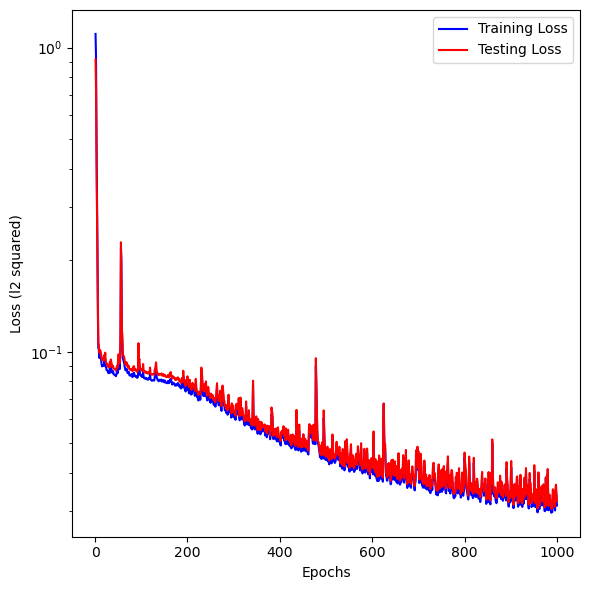

In [14]:
## Plotting the loss history
num_epoch = model.train_loss_log.shape[0]
x = np.linspace(1, num_epoch, num_epoch)
fig = plt.figure(constrained_layout=False, figsize=(6, 6))
gs = fig.add_gridspec(1, 1)
ax = fig.add_subplot(gs[0])
ax.plot(x, model.train_loss_log[:, 0], color='blue', label='Training Loss')
ax.plot(x, model.test_loss_log[:, 0], color='red', label='Testing Loss')
ax.set_yscale('log')
ax.set_ylabel('Loss (l2 squared)')
ax.set_xlabel('Epochs')
ax.legend(loc='best')
fig.tight_layout()
fig.savefig(results_dir+'loss_his.png',  bbox_inches='tight')
plt.show()

## Test and plot the output of network

In [15]:
Y_test = test_data['Y_train']
Y_test_pred = model.predict(test_data).detach().numpy()

print('test_out shape: {}, test_pred shape: {}'.format(Y_test.shape, Y_test_pred.shape))

error = np.linalg.norm(Y_test - Y_test_pred, axis = 1)/np.linalg.norm(Y_test, axis = 1)

print('Num tests: {:5d}, Mean Loss (rel l2): {:.3e}, Std Loss (rel l2): {:.3e}'.format(num_test, np.mean(error), np.std(error)))

test_out shape: (100, 2601), test_pred shape: (100, 2601)
Num tests:   100, Mean Loss (rel l2): 2.472e-01, Std Loss (rel l2): 1.334e-01


In [16]:
def get_FE_space(mesh_file = data_folder + 'LinearElasticity_u_mesh.xdmf', is_vector = False):
    mesh = dl.Mesh()
    with dl.XDMFFile(mesh_file) as infile:
        infile.read(mesh)
    if is_vector:
        V = dl.VectorFunctionSpace(mesh, "Lagrange", 1)
    else:
        V = dl.FunctionSpace(mesh, "Lagrange", 1)
    return V

i_plot =    26, error (rel l2): 6.891e-02
i_plot =    86, error (rel l2): 4.064e-02
i_plot =     2, error (rel l2): 3.495e-02
i_plot =    55, error (rel l2): 2.487e-02
i_plot =    75, error (rel l2): 3.792e-02
i_plot =    93, error (rel l2): 9.105e-02
i_plot =    16, error (rel l2): 5.079e-02
i_plot =    73, error (rel l2): 2.658e-02
i_plot =    54, error (rel l2): 9.136e-02
i_plot =    95, error (rel l2): 1.733e-02
i_plot =    53, error (rel l2): 9.494e-02
i_plot =    92, error (rel l2): 2.173e-02
i_plot =    78, error (rel l2): 2.648e-02
i_plot =    13, error (rel l2): 2.355e-02
i_plot =     7, error (rel l2): 9.389e-02
i_plot =    30, error (rel l2): 1.642e-01


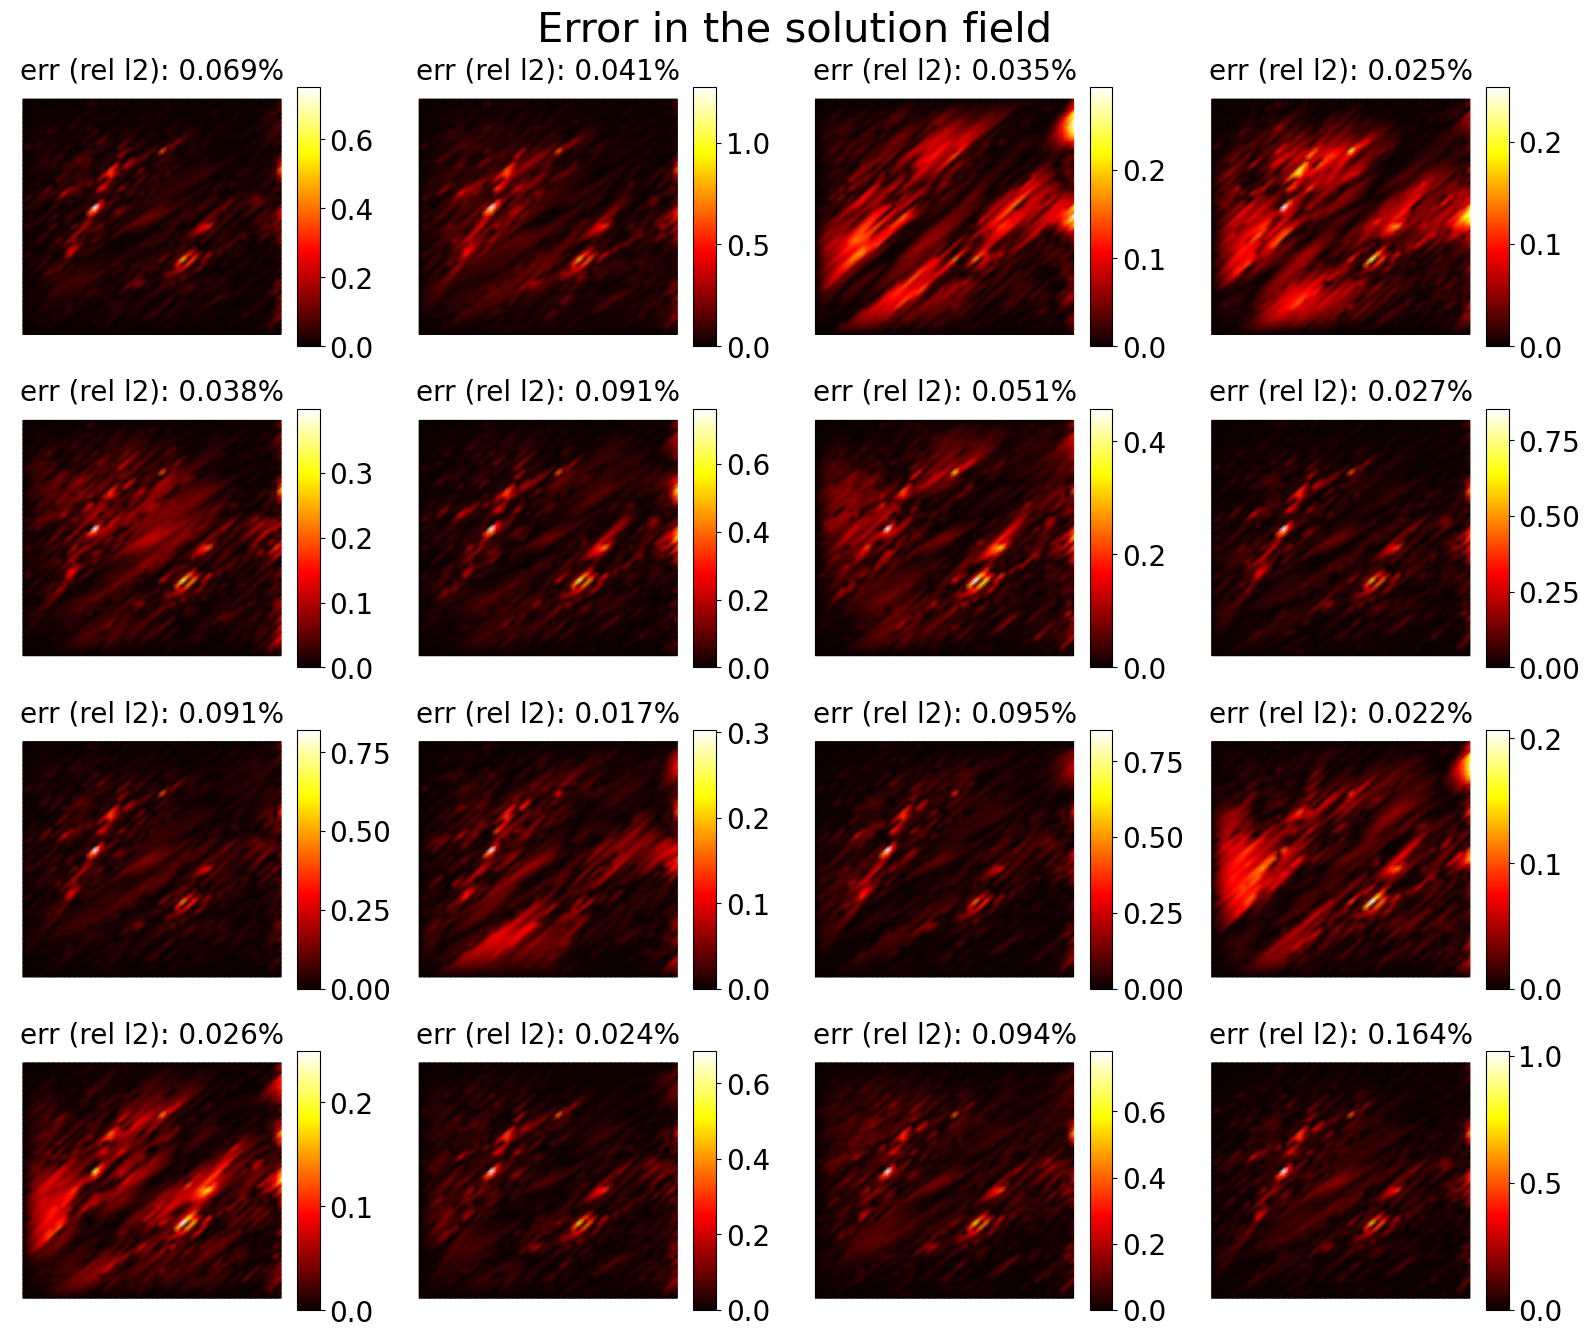

In [17]:
rows, cols = 4, 4
fs = 20
fig, axs = plt.subplots(rows, cols, figsize=(16, 13))

decode = True

Vu = get_FE_space(data_folder + data_prefix + '_u_mesh.xdmf')
Vm = get_FE_space(data_folder + data_prefix + '_m_mesh.xdmf')

Y_spatial_points = data.X_trunk

# randomly choose rows number of samples
i_choices = np.random.choice(num_test, rows*cols, replace=False)

for i in range(rows):
    for j in range(cols):
        i_plot = i_choices[i*cols + j]

        i_pred = Y_test_pred[i_plot]
        i_truth = Y_test[i_plot]
        if decode:
            i_pred = data.decoder_Y(i_pred)
            i_truth = data.decoder_Y(i_truth)

        i_diff = i_pred - i_truth
        i_diff_norm = np.linalg.norm(i_diff) / np.linalg.norm(i_truth)
        print('i_plot = {:5d}, error (rel l2): {:.3e}'.format(i_plot, i_diff_norm))

        nodes = Y_spatial_points

        cbar = field_plot_fenics(axs[i,j], i_diff, Vu, cmap = 'hot')

        divider = make_axes_locatable(axs[i,j])
        cax = divider.append_axes('right', size='8%', pad=0.03)
        cax.tick_params(labelsize=fs)
        fig.colorbar(cbar, cax=cax, orientation='vertical')

        err_str = 'err (rel l2): {:.3f}%'.format(i_diff_norm)
        axs[i,j].set_title(err_str, fontsize=fs)

        axs[i,j].axis('off')

fig.tight_layout()
fig.suptitle('Error in the solution field', fontsize=1.5*fs, y=1.025)
fig.savefig(results_dir+'sample_error_plots.png',  bbox_inches='tight')
plt.show()


i_plot =    18, error (rel l2): 3.038e-02
i_plot =    29, error (rel l2): 1.965e-02
i_plot =    64, error (rel l2): 1.579e-02
i_plot =    92, error (rel l2): 2.173e-02


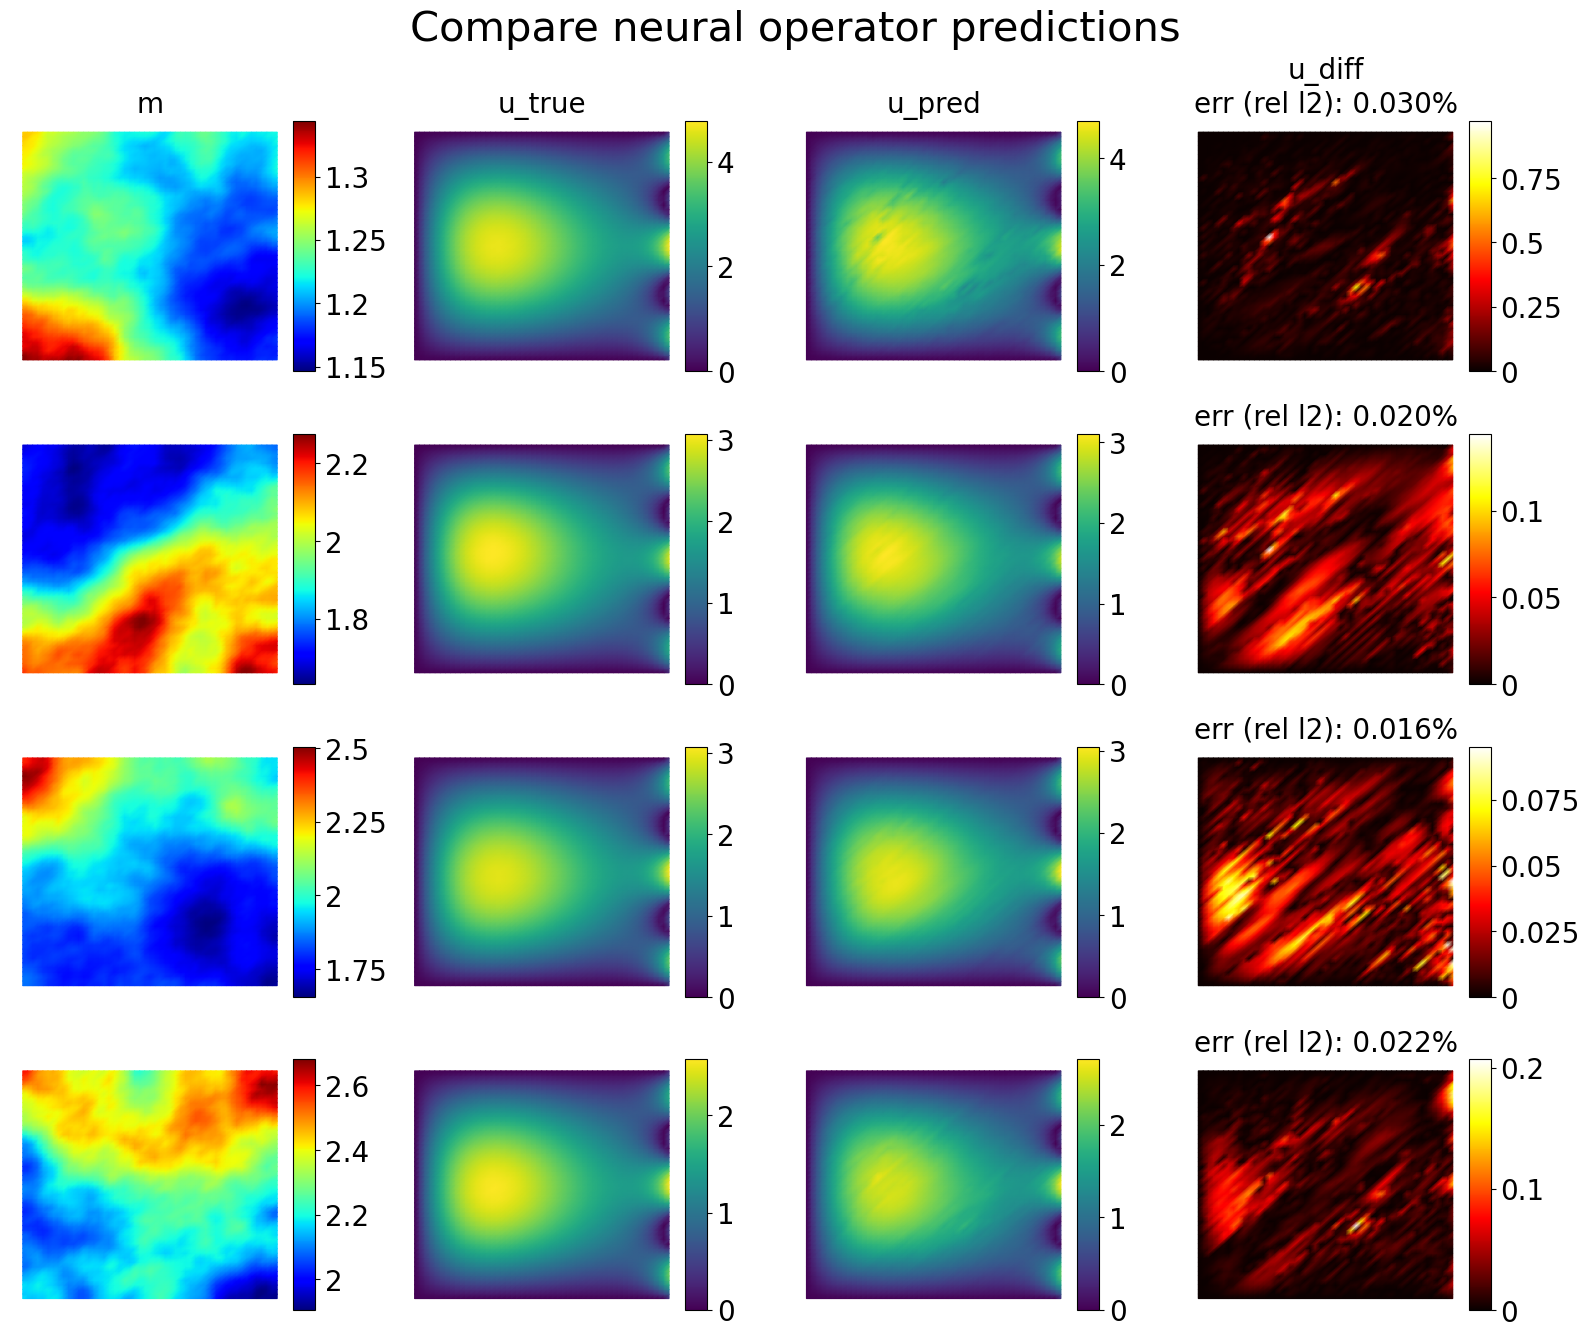

In [18]:
rows, cols = 4, 4
fs = 20
fig, axs = plt.subplots(rows, cols, figsize=(16, 13))

decode = True

Vu = get_FE_space(data_folder + data_prefix + '_u_mesh.xdmf')
Vm = get_FE_space(data_folder + data_prefix + '_m_mesh.xdmf')

# row: m, u_true, u_pred, u_diff
u_tags = ['m', 'u_true', 'u_pred', 'u_diff']
cmaps = ['jet', 'viridis', 'viridis', 'hot']
Vvec = [Vm, Vu, Vu, Vu]
Y_spatial_points = data.X_trunk # for this problem, nodes are same for m and u functions
X_spatial_points = Y_spatial_points

# randomly choose rows number of samples
i_choices = np.random.choice(num_test, rows, replace=False)

for i in range(rows):
    
    i_plot = i_choices[i]

    i_pred = Y_test_pred[i_plot]
    i_truth = Y_test[i_plot]
    i_m_test = data.X_test[i_plot]
    if decode:
        i_pred = data.decoder_Y(i_pred)
        i_truth = data.decoder_Y(i_truth)
        i_m_test = data.decoder_X(i_m_test)
            
    i_diff = i_pred - i_truth
    i_diff_norm = np.linalg.norm(i_diff) / np.linalg.norm(i_truth)
    print('i_plot = {:5d}, error (rel l2): {:.3e}'.format(i_plot, i_diff_norm))

    uvec = [i_m_test, i_truth, i_pred, i_diff]
    
    for j in range(cols):
        nodes = Y_spatial_points if j > 0 else X_spatial_points
        
        cbar = field_plot_fenics(axs[i,j], uvec[j], Vvec[j], cmap = cmaps[j])

        divider = make_axes_locatable(axs[i,j])
        cax = divider.append_axes('right', size='8%', pad=0.03)
        cax.tick_params(labelsize=fs)

        if j == 0 or j == cols - 1:
            # format cbar ticks
            kfmt = lambda x, pos: "{:g}".format(x)
            
            cbar = fig.colorbar(cbar, cax=cax, orientation='vertical', format = kfmt)
        else:
            cbar = fig.colorbar(cbar, cax=cax, orientation='vertical')

        if i == 0 and j < cols - 1:
            axs[i,j].set_title(u_tags[j], fontsize=fs)
        
        if j == cols - 1:
            err_str = 'err (rel l2): {:.3f}%'.format(i_diff_norm)
            if i == 0:
                err_str = u_tags[j] + '\n' + err_str
            axs[i,j].set_title(err_str, fontsize=fs)

        axs[i,j].axis('off')

fig.tight_layout()
fig.suptitle('Compare neural operator predictions', fontsize=1.5*fs, y=1.025)
fig.savefig(results_dir+'neural_operator_prediction_comparison.png',  bbox_inches='tight')
plt.show()

